In [1]:
import pandas as pd
import numpy as np

In [2]:
trainee = pd.read_csv('trainees.csv')

In [3]:
trainee.head()

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100


# No control whatsoever

## A simple diff in means of trained vs untrained

In [4]:
## A simple diff in means
simple_diff = np.round(((trainee.query('trainees==1').earnings.mean()) - (trainee.query('trainees==0').earnings.mean())))
print(f"simple diff in [trained - untrained] means = {simple_diff}")

simple diff in [trained - untrained] means = -4297.0


## OLS based simple diff

In [5]:
import statsmodels.formula.api as smf

In [6]:
simple_ols = smf.ols("earnings ~ trainees", data = trainee).fit()

In [7]:
simple_ols.params   ## Simople diff in means

Intercept    20723.809524
trainees     -4297.493734
dtype: float64

# Control for age

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='age', ylabel='earnings'>

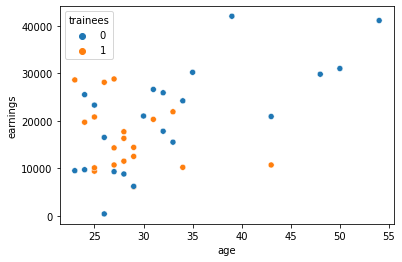

In [9]:
sns.scatterplot(x = "age", y = "earnings", hue = "trainees", data = trainee)

<AxesSubplot:xlabel='age', ylabel='Density'>

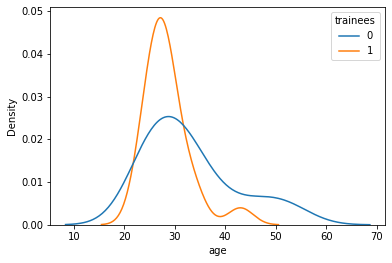

In [10]:
sns.kdeplot(x = "age", hue="trainees", data = trainee)

## Trainees are much younger than non-trainees

This leads to confounding

In [11]:
age_controled_ols = smf.ols("earnings ~ trainees + age", data = trainee).fit()

In [12]:
age_controled_ols.params   ## Still leads to a net negative effect

Intercept     626.902472
trainees    -1540.980167
age           608.997183
dtype: float64

### Still leads to a net negative effect

# Balance/match the dataset

**SIMPLE MATCHING**: Make the `trainees==0` dataset unique on age and then join it with the `trainees==1` dataset on `age`.

In [13]:
trainee.query('trainees==0').count()[0]

21

In [14]:
unique_non_trainees = trainee.query('trainees==0').drop_duplicates(subset=['age'])
unique_non_trainees.count()[0]

18

In [19]:
## Join this with the trainees==1 data
matched_trainees = (trainee
.query("trainees == 1")
.merge(unique_non_trainees, on = 'age', how='left', suffixes = ('_t_1', '_t_0'))
.assign(t1_minus_t0 = lambda d: d['earnings_t_1'] - d['earnings_t_0'])
)

In [20]:
unique_non_trainees

,unit,trainees,age,earnings
19,20,0,43,20900
20,21,0,50,31000
21,22,0,30,21000
22,23,0,27,9300
23,24,0,54,41100
24,25,0,48,29800
25,26,0,39,42000
26,27,0,28,8800
27,28,0,24,25500
28,29,0,33,15500


In [21]:
matched_trainees

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0,t1_minus_t0
0,1,1,28,17700,27,0,8800,8900
1,2,1,34,10200,34,0,24200,-14000
2,3,1,29,14400,37,0,6200,8200
3,4,1,25,20800,35,0,23300,-2500
4,5,1,29,6100,37,0,6200,-100
5,6,1,23,28600,40,0,9500,19100
6,7,1,33,21900,29,0,15500,6400
7,8,1,27,28800,23,0,9300,19500
8,9,1,31,20300,32,0,26600,-6300
9,10,1,26,28100,31,0,400,27700


In [22]:
matched_trainees.t1_minus_t0.mean()   ## This is net positive effect of training

2457.8947368421054

### The net effect of training after adjusting for age is +2457 (net positive effect)

# Test: Use `age` as the random effect

In [23]:
## Bin the age

trainee_grouped = (trainee
.assign(age_group = lambda d: pd.cut(d.age, 10, labels=[1,2,3,4,5,6,7,8,9,0]))
)

In [24]:
trainee_grouped.head()

,unit,trainees,age,earnings,age_group
0,1,1,28,17700,2
1,2,1,34,10200,4
2,3,1,29,14400,2
3,4,1,25,20800,1
4,5,1,29,6100,2


In [25]:
age_grouped = smf.mixedlm("earnings ~ trainees", data = trainee_grouped, groups=trainee_grouped['age_group']).fit()

In [26]:
age_grouped.params

Intercept    23496.470540
trainees       638.904491
Group Var        1.559684
dtype: float64

## Does not work

The net effect is positive, but, not the correct value. Probably suffers from some control values having bins that do not exist in treatment set

## Filter for `age_group` buckets that exists in treatment group

In [27]:
trainee_grouped.query('trainees==1').age_group.unique()   ## Only 1,2,3,4,7 exists in treatment group

[2, 4, 1, 3, 7]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 0]

In [28]:
trainee_grouped_filtered = trainee_grouped[trainee_grouped.age_group.isin([1, 2, 3, 4, 7])]
trainee_grouped_filtered.count()[0]

36

In [29]:
age_grouped_bucketed = smf.mixedlm("earnings ~ trainees", data = trainee_grouped_filtered, groups=trainee_grouped_filtered['age_group']).fit()

In [30]:
age_grouped_bucketed.params

Intercept    17019.767949
trainees       670.599284
Group Var        0.160964
dtype: float64

# Does not Work

# Using logistic regression to balance the covariates

In [31]:
logistic_model1 = smf.logit("trainees ~ age", data = trainee).fit()

Optimization terminated successfully.
         Current function value: 0.639952
         Iterations 6


In [32]:
predicted_vals = logistic_model1.predict()

<AxesSubplot:ylabel='Density'>

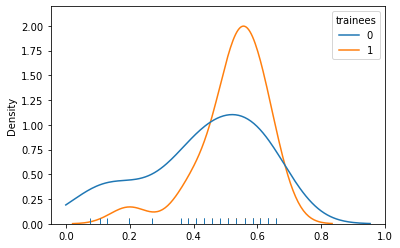

In [33]:
sns.kdeplot(x = predicted_vals, hue= trainee.trainees, clip = [0.0, 1.0])
sns.rugplot(x = predicted_vals,  hue= trainee.trainees)

## We can take the range between 0.2 till 0.65

In [34]:
trainee_proScores = trainee
trainee_proScores['proScore'] = logistic_model1.predict()
trainee_proScores = trainee_proScores.query("proScore >= 0.2 and proScore <= 0.65")

In [35]:
len(trainee_proScores)

33

In [36]:
trainee_proScores.head()

,unit,trainees,age,earnings,proScore
0,1,1,28,17700,0.534316
1,2,1,34,10200,0.383166
2,3,1,29,14400,0.508802
3,4,1,25,20800,0.609279
4,5,1,29,6100,0.508802


### Match based on proScores

Using the sklearn `KNeighborsRegressor` function

In [37]:
from sklearn.neighbors import KNeighborsRegressor

### Create a model for the untreated units and fit treated units to get their neighboring untreated units

In [38]:
untreated = trainee_proScores.query("trainees==0")
treated = trainee_proScores.query("trainees==1")

In [39]:
X = ['age']
y = 'earnings'
D = 'trainees'
ps = ['proScore']

In [40]:
## Model for untreated units based on AGE
model_t0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])

In [41]:
treated = treated.assign(neighbor_pred = model_t0.predict(treated[X]))

In [42]:
treated

,unit,trainees,age,earnings,proScore,neighbor_pred
0,1,1,28,17700,0.534316,8800.0
1,2,1,34,10200,0.383166,24200.0
2,3,1,29,14400,0.508802,6200.0
3,4,1,25,20800,0.609279,23300.0
4,5,1,29,6100,0.508802,6200.0
6,7,1,33,21900,0.407607,15500.0
7,8,1,27,28800,0.559651,9300.0
8,9,1,31,20300,0.457769,26600.0
9,10,1,26,28100,0.584680,400.0
10,11,1,25,9400,0.609279,23300.0


In [43]:
## This should be the same as unique
matched_trainees

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0,t1_minus_t0
0,1,1,28,17700,27,0,8800,8900
1,2,1,34,10200,34,0,24200,-14000
2,3,1,29,14400,37,0,6200,8200
3,4,1,25,20800,35,0,23300,-2500
4,5,1,29,6100,37,0,6200,-100
5,6,1,23,28600,40,0,9500,19100
6,7,1,33,21900,29,0,15500,6400
7,8,1,27,28800,23,0,9300,19500
8,9,1,31,20300,32,0,26600,-6300
9,10,1,26,28100,31,0,400,27700


In [44]:
help(KNeighborsRegressor)

Help on class KNeighborsRegressor in module sklearn.neighbors._regression:

class KNeighborsRegressor(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.RegressorMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  .. versionadded:: 0.9
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |      

In [63]:
## Model for untreated units based on proScore
model_t0_ps = KNeighborsRegressor(n_neighbors=1).fit(untreated[ps], untreated[y])
model_t1_ps = KNeighborsRegressor(n_neighbors=1).fit(treated[ps], treated[y])

In [64]:
treated = treated.assign(neighbor_pred_ps = model_t0_ps.predict(treated[ps]))
untreated = untreated.assign(neighbor_pred_ps = model_t1_ps.predict(untreated[ps]))

In [65]:
complete_neighbors = pd.concat([treated, untreated], axis=0)

In [67]:
complete_neighbors = complete_neighbors.assign(t1_minus_t0 = lambda d: d.neighbor_pred_ps - d.earnings)
complete_neighbors

,unit,trainees,age,earnings,proScore,neighbor_pred,neighbor_pred_ps,t1_minus_t0
0,1,1,28,17700,0.534316,8800.0,8800.0,-8900.0
1,2,1,34,10200,0.383166,24200.0,24200.0,14000.0
2,3,1,29,14400,0.508802,6200.0,6200.0,-8200.0
3,4,1,25,20800,0.609279,23300.0,23300.0,2500.0
4,5,1,29,6100,0.508802,6200.0,6200.0,100.0
6,7,1,33,21900,0.407607,15500.0,15500.0,-6400.0
7,8,1,27,28800,0.559651,9300.0,9300.0,-19500.0
8,9,1,31,20300,0.457769,26600.0,26600.0,6300.0
9,10,1,26,28100,0.584680,400.0,400.0,-27700.0
10,11,1,25,9400,0.609279,23300.0,23300.0,13900.0


In [68]:
complete_neighbors.t1_minus_t0.mean()  ## sees problem due to diff no.s of age groups

-803.030303030303

### These values are the same

## Actual diff computation

$\hat{ATE} = \frac{1}{N} \sum^N_{i=0} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)$

In [70]:
ATE = np.mean((2* complete_neighbors['trainees'] - 1) * (complete_neighbors['earnings'] - complete_neighbors['neighbor_pred_ps']))
print(f" Average treatment effect ATE = {ATE}")

 Average treatment effect ATE = 1487.878787878788


In [73]:
ATT = np.mean((complete_neighbors.query("trainees==1")['earnings'] - complete_neighbors.query("trainees==1")['neighbor_pred_ps']))
print(f" Average treatment effect ATT = {ATT}")

 Average treatment effect ATT = 2223.529411764706


# Bias corrected ATT

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
untreated

,unit,trainees,age,earnings,proScore,neighbor_pred_ps
21,22,0,30,21000,0.483242,20300.0
22,23,0,27,9300,0.559651,28800.0
25,26,0,39,42000,0.271411,10200.0
26,27,0,28,8800,0.534316,17700.0
27,28,0,24,25500,0.633336,19700.0
28,29,0,33,15500,0.407607,21900.0
29,31,0,26,400,0.584680,28100.0
30,32,0,31,26600,0.457769,20300.0
31,33,0,26,16500,0.584680,28100.0
32,34,0,34,24200,0.383166,10200.0


In [76]:
## Model the untreated and then predict the treated using that model
t0_model_lr = LinearRegression().fit(untreated[X], untreated[y])

In [77]:
treated

,unit,trainees,age,earnings,proScore,neighbor_pred,neighbor_pred_ps,t1_minus_t0
0,1,1,28,17700,0.534316,8800.0,8800.0,8900.0
1,2,1,34,10200,0.383166,24200.0,24200.0,-14000.0
2,3,1,29,14400,0.508802,6200.0,6200.0,8200.0
3,4,1,25,20800,0.609279,23300.0,23300.0,-2500.0
4,5,1,29,6100,0.508802,6200.0,6200.0,-100.0
6,7,1,33,21900,0.407607,15500.0,15500.0,6400.0
7,8,1,27,28800,0.559651,9300.0,9300.0,19500.0
8,9,1,31,20300,0.457769,26600.0,26600.0,-6300.0
9,10,1,26,28100,0.584680,400.0,400.0,27700.0
10,11,1,25,9400,0.609279,23300.0,23300.0,-13900.0


In [79]:
treated = (treated
.assign(t0_model_lr_term = t0_model_lr.predict(treated[X]))
.assign(bias_term = lambda d: d.t0_model_lr_term - d.neighbor_pred)
.assign(bias_corrected_term = lambda d: (d.earnings - d.neighbor_pred) - d.bias_term)
)

In [80]:
treated

,unit,trainees,age,earnings,proScore,neighbor_pred,neighbor_pred_ps,t1_minus_t0,t0_model_lr_term,bias_term,bias_corrected_term
0,1,1,28,17700,0.534316,8800.0,8800.0,8900.0,16329.247169,7529.247169,1370.752831
1,2,1,34,10200,0.383166,24200.0,24200.0,-14000.0,25580.812791,1380.812791,-15380.812791
2,3,1,29,14400,0.508802,6200.0,6200.0,8200.0,17871.174772,11671.174772,-3471.174772
3,4,1,25,20800,0.609279,23300.0,23300.0,-2500.0,11703.464357,-11596.535643,9096.535643
4,5,1,29,6100,0.508802,6200.0,6200.0,-100.0,17871.174772,11671.174772,-11771.174772
6,7,1,33,21900,0.407607,15500.0,15500.0,6400.0,24038.885188,8538.885188,-2138.885188
7,8,1,27,28800,0.559651,9300.0,9300.0,19500.0,14787.319565,5487.319565,14012.680435
8,9,1,31,20300,0.457769,26600.0,26600.0,-6300.0,20955.029980,-5644.970020,-655.029980
9,10,1,26,28100,0.584680,400.0,400.0,27700.0,13245.391961,12845.391961,14854.608039
10,11,1,25,9400,0.609279,23300.0,23300.0,-13900.0,11703.464357,-11596.535643,-2303.464357


In [91]:
treated.t1_minus_t0.mean()

2223.529411764706

In [98]:
treated_melted = treated.melt(id_vars=['unit', 'age'], value_vars=['earnings','neighbor_pred'])

In [99]:
treated_melted

,unit,age,variable,value
0,1,28,earnings,17700.0
1,2,34,earnings,10200.0
2,3,29,earnings,14400.0
3,4,25,earnings,20800.0
4,5,29,earnings,6100.0
5,7,33,earnings,21900.0
6,8,27,earnings,28800.0
7,9,31,earnings,20300.0
8,10,26,earnings,28100.0
9,11,25,earnings,9400.0


In [101]:
test_model = smf.ols("value ~ variable + age", data = treated_melted).fit()

In [102]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.3937
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.678
Time:                        18:58:05   Log-Likelihood:                -351.01
No. Observations:                  34   AIC:                             708.0
Df Residuals:                      31   BIC:                             712.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.997e+04   1.39e+04      1.439      0.160   -8328.403    4.83e+04
variable[T.neighbor_pred] -2223.5294   2646.500     -0.840      0.407   -7621.102    3174.043
age                        -140.4306    492.060     -0.285      0.777   -1143.993     863.131
==============================================================================
Omnibus:                        5.056   Durbin-Watson:                   2.656
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                2.411
Skew:                           0.368   Prob(JB):                        0.299
Kurtosis:                       1.923   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
treated.bias_corrected_term.mean()

-191.48672127078746

In [83]:
from causalinference import CausalModel

cm = CausalModel(
    Y=trainee["earnings"].values, 
    D=trainee["trainees"].values, 
    X=trainee[["age"]].values
)

In [89]:
cm.est_via_matching(matches=1, bias_adj=True)

C:\Users\usbahadura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [90]:
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE  -1101.446   4815.098     -0.229      0.819 -10539.039   8336.147
           ATC  -4314.660   4889.464     -0.882      0.378 -13898.009   5268.689
           ATT   2450.000   5892.248      0.416      0.678  -9098.806  13998.806

